In [1]:
import numpy as np
from nuscenes.utils.geometry_utils import view_points, transform_matrix
from nuscenes.utils.data_classes import Box
from pyquaternion import Quaternion
from tqdm import tqdm
from nuscenes.nuscenes import NuScenes
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from nuscenes.utils.geometry_utils import  BoxVisibility

def get_nuscences_dicts(path="./", version='v1.0-mini', categories=None):
    """
    This is a helper fuction that create dicts from nuscenes to detectron2 format.
    Nuscenes annotation use 3d bounding box, but for detectron we need 2d bounding box.
    The simplest solution is get max x, min x, max y and min y coordinates from 3d bb and 
    create 2d box. So we lost accuracy, but this is not critical.
    :param path: <string>. Path to Nuscenes dataset.
    :param version: <string>. Nuscenes dataset version name.
    :param categories <list<string>>. List of selected categories for detection. 
        Get from https://www.nuscenes.org/data-annotation 
        Categories names:
            ['human.pedestrian.adult',
             'human.pedestrian.child',
             'human.pedestrian.wheelchair',
             'human.pedestrian.stroller',
             'human.pedestrian.personal_mobility',
             'human.pedestrian.police_officer',
             'human.pedestrian.construction_worker',
             'animal',
             'vehicle.car',
             'vehicle.motorcycle',
             'vehicle.bicycle',
             'vehicle.bus.bendy',
             'vehicle.bus.rigid',
             'vehicle.truck',
             'vehicle.construction',
             'vehicle.emergency.ambulance',
             'vehicle.emergency.police',
             'vehicle.trailer',
             'movable_object.barrier',
             'movable_object.trafficcone',
             'movable_object.pushable_pullable',
             'movable_object.debris',
             'static_object.bicycle_rack']
    :return: <dict>. Return dict with data annotation in detectron2 format.
    """
    assert(path[-1] == "/"), "Insert '/' in the end of path"
    nusc = NuScenes(version=version, dataroot=path, verbose=False)
    
    # Select all catecategories if not set 
    if categories == None:
        categories = [data["name"] for data in nusc.category]
    assert(isinstance(categories, list)), "Categories type must be list"
    
    dataset_dicts = []
    idx = 0
    for i in tqdm(range(0, len(nusc.scene))):
        scene = nusc.scene[i]
        scene_rec = nusc.get('scene', scene['token'])
        sample_rec_cur = nusc.get('sample', scene_rec['first_sample_token'])
        
        # Go through all frame in current scene
        while True: 
            data = nusc.get('sample_data', sample_rec_cur['data']["CAM_FRONT"])

            record = {}
            record["file_name"] = path + data["filename"]
            record["image_id"] = idx
            record["height"] = data["height"]
            record["width"] = data["width"]
            idx += 1
            
            # Get boxes from front camera
            _, boxes, camera_intrinsic = nusc.get_sample_data(sample_rec_cur['data']["CAM_FRONT"], BoxVisibility.ANY)
            # Get only necessary boxes
            boxes = [box for box in boxes if box.name in categories]
            # Go through all bounding boxes
            objs = []
            for box in boxes: 
                corners = view_points(box.corners(), camera_intrinsic, normalize=True)[:2, :]
                max_x = int(max(corners[:][0]))
                min_x = int(min(corners[:][0]))
                max_y = int(max(corners[:][1]))
                min_y = int(min(corners[:][1]))
                obj = {
                    "bbox": [min_x, min_y, max_x, max_y],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": categories.index(box.name),
                    "iscrowd": 0
                }
                objs.append(obj)
                
            record["annotations"] = objs
            dataset_dicts.append(record)
            
            # Get next frame
            sample_rec_cur = nusc.get('sample', sample_rec_cur['next'])
            # End of scene condition
            if (sample_rec_cur["next"] == ""):
                break
                
    return dataset_dicts

categories = ['human.pedestrian.adult',
              'human.pedestrian.child',
              'human.pedestrian.wheelchair',
              'human.pedestrian.stroller',
              'human.pedestrian.personal_mobility',
              'human.pedestrian.police_officer',
              'human.pedestrian.construction_worker',
              'vehicle.car',
              'vehicle.bus.bendy',
              'vehicle.bus.rigid',
              'vehicle.truck',
              'vehicle.construction',
              'vehicle.emergency.ambulance',
              'vehicle.emergency.police',
              'vehicle.trailer']

DatasetCatalog.register("nusc_mini", lambda path="./v1-mini/", categories=categories: get_nuscences_dicts(path=path, categories=categories))
MetadataCatalog.get("nusc_mini").thing_classes = categories

100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


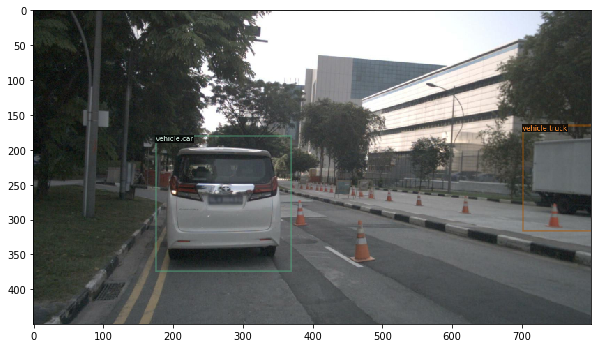

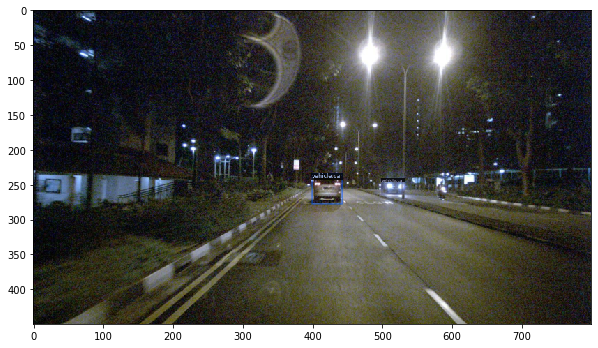

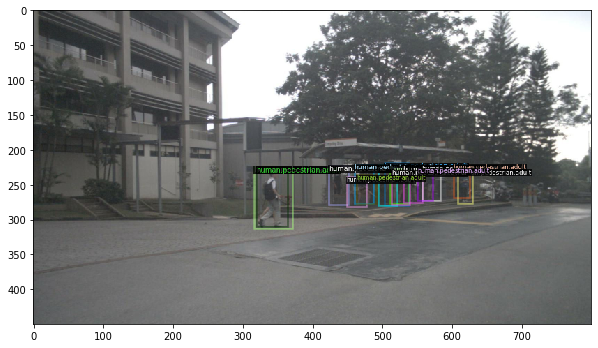

In [2]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from matplotlib import pyplot as plt
%matplotlib inline

dataset_dicts = get_nuscences_dicts("./v1-mini/", categories=categories)
nusc_metadata = MetadataCatalog.get("nusc_mini")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=nusc_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111)
    ax.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [8]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# If using cpu
cfg.MODEL.DEVICE = "cpu" 
predictor = DefaultPredictor(cfg)



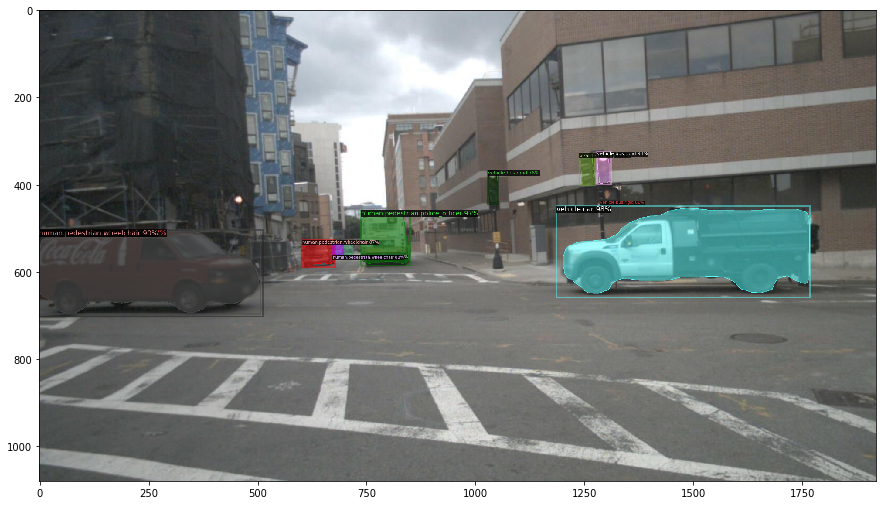

In [39]:
d = random.sample(dataset_dicts, 1)[0]
im = cv2.imread(d["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], nusc_metadata, scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))